In [8]:
!ls -l data/v1.0-mini/v1.0-mini/

итого 32540
-rw-r--r-- 1 narekvslife narekvslife     1147 мар 22  2019 attribute.json
-rw-r--r-- 1 narekvslife narekvslife    38486 мар 22  2019 calibrated_sensor.json
-rw-r--r-- 1 narekvslife narekvslife     4747 мар 22  2019 category.json
-rw-r--r-- 1 narekvslife narekvslife  7654286 мар 22  2019 ego_pose.json
-rw-r--r-- 1 narekvslife narekvslife   226647 мар 22  2019 instance.json
-rw-r--r-- 1 narekvslife narekvslife     1412 мар 22  2019 log.json
-rw-r--r-- 1 narekvslife narekvslife     3606 мар 22  2019 map.json
-rw-r--r-- 1 narekvslife narekvslife  9307571 мар 22  2019 sample_annotation.json
-rw-r--r-- 1 narekvslife narekvslife 15960620 мар 22  2019 sample_data.json
-rw-r--r-- 1 narekvslife narekvslife    87838 мар 22  2019 sample.json
-rw-r--r-- 1 narekvslife narekvslife     3513 мар 22  2019 scene.json
-rw-r--r-- 1 narekvslife narekvslife     1185 мар 22  2019 sensor.json
-rw-r--r-- 1 narekvslife narekvslife      418 мар 22  2019 visibility.json


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from os.path import join 

from src.models.dla import FeatureExtractorBlock, DeepLayerAggregation
from src.datasets import NuscenesRangeViewDataset
from src.settings import RV_HEIGHT, RV_WIDTH

from nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, transform_matrix
from nuscenes.utils.data_classes import LidarPointCloud

from PIL import Image
from pyquaternion import Quaternion

NUSCENES = NuscenesRangeViewDataset(version='v1.0-mini', data_root='./data/v1.0-mini/')

./data/v1.0-mini/ v1.0-mini
Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.287 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


/home/narekvslife/lidar-camera-fusion-detection/src/datasets.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.point_clouds_features = np.array(self.point_clouds_features)
/home/narekvslife/lidar-camera-fusion-detection/src/datasets.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.point_clouds_labels = np.array(self.point_clouds_labels)


In [24]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        
        self.fe1 = FeatureExtractorBlock(in_channels= 3, out_channels=16, stride=(2, 2), n=3)
        self.fe2 = FeatureExtractorBlock(in_channels=16, out_channels=24, stride=(2, 2), n=3)        
        self.fe3 = FeatureExtractorBlock(in_channels=24, out_channels=32, stride=(2, 2), n=3)
        
    def forward(self, x):
        x = self.fe1(x)
        x = self.fe2(x)
        x = self.fe3(x)
        return x

(900, 1600, 3)


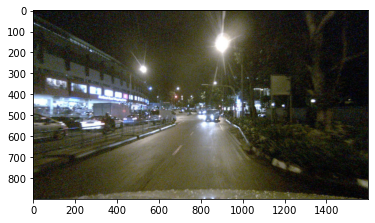

In [25]:
my_sample = NUSCENES.samples[349]
camera_token = my_sample['data']["CAM_BACK"]
image_file = NUSCENES.nuscenes.get('sample_data', camera_token)['filename']
image = Image.open(join(NUSCENES.data_root, image_file))

IMAGE_HEIGHT = 900
IMAGE_WIDTH = 1600

print(np.array(image).shape)
plt.imshow(image)
plt.show()

In [26]:
im = torch.rand((16, 3, 1600, 900))
fe = ImageFeatureExtractor()

fe(im)
print()

In [79]:
def map_pointcloud_to_image(range_view,
                            pointsensor_token: str,
                            camera_token: str,
                            min_dist: float = 1.0):
    """
    Given a point sensor (lidar) token and camera sample_data token, load pointcloud and map it to the image
    plane.
   
    :param pointsensor_token: Lidar/radar sample_data token.
    :param camera_token: Camera sample_data token.
    :param min_dist: Distance from the camera below which points are discarded.
    
    :return (pointcloud <np.float: 2, n)>)
    """

    cam = NUSCENES.nuscenes.get('sample_data', camera_token)
    pointsensor = NUSCENES.nuscenes.get('sample_data', pointsensor_token)
    pcl_path = join(NUSCENES.data_root, pointsensor['filename'])

    x, y, z, r = range_view[:4]
    features_flat = np.vstack((x.flatten(), y.flatten(), z.flatten(), r.flatten()))
    pc = LidarPointCloud(features_flat)

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = NUSCENES.nuscenes.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    poserecord = NUSCENES.nuscenes.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = NUSCENES.nuscenes.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    cs_record = NUSCENES.nuscenes.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

    return points.reshape(3, RV_WIDTH, RV_HEIGHT)[:2]  # we are only interested in xy coordinates

In [80]:
range_view, range_view_labels, _ = NUSCENES[0]
mapping = map_pointcloud_to_image(range_view.cpu().numpy(),
                                  my_sample['data']['LIDAR_TOP'], 
                                  my_sample['data']['CAM_FRONT'])

mapping.shape

(2, 256, 32)

In [78]:
class LaserNetPP(nn.Module):
    def __init__(self):
        super(LaserNetPP, self).__init__()

        self.camera_cnn = ImageFeatureExtractor()  # after this, image.width = initial_width / 8  
        self.lidar_cnn = nn.Conv2d(in_channels=5, 
                                   out_channels=32, 
                                   kernel_size=(3, 3))
        
        self.dla = DeepLayerAggregation(in_channels=64)  # 32 from image_cnn + 32 from lidar_cnn
    
    def forward(self, range_views, images):
        """
        range_views.shape =  N x 7 x RV_WIDTH x RV_HEIGHT 
        (first two dimensions being xy coordinates of a corrsepsonding point that got into the rv cell)
        
        images.shape = N x 3 x IM_WIDTH x IM_HEIGHT 
        """
        
        # padding to perseive range_view width and height dimensions after conv
        range_view_features = self.lidar_cnn(F.pad(range_views, (1, 1, 1, 1)))
        image_features = self.camera_cnn(image)  # 